In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
import pickle

import util
from ts_net import TsNet

import logging
logging.basicConfig(level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(name)s: %(message)s")
logger = logging.getLogger(__name__)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class Args:
    def __init__(self, data_dir, target_obj, batch_size, win_size, corr_coef_pp, n_fold, rand_seed, max_epochs, log_n_iter, logdir, verbose):
        self.data_dir = data_dir
        self.target_obj = target_obj
        self.batch_size = batch_size
        self.win_size = win_size
        self.corr_coef_pp = corr_coef_pp
        self.n_fold = n_fold
        self.rand_seed = rand_seed
        self.max_epochs = max_epochs
        self.logdir = logdir
        self.verbose = verbose

In [3]:
# # configs

root_dir = "/home/yujin/ts_prediction_keras/data"
target_object = "Dog_1"
batch_size = 32
win_size = 8000
corr_coef_pp = 0.0
n_fold = 3
rand_seed = 11
max_epochs = 20
logdir = "./log"
verbose = 0

args = Args(data_dir = root_dir,
            target_obj = target_object,
            batch_size = batch_size,
            win_size = win_size,
            corr_coef_pp = corr_coef_pp,
            n_fold = n_fold,
            rand_seed = rand_seed,
            max_epochs = max_epochs,
            log_n_iter = log_n_iter,
            logdir = logdir,
            verbose = verbose
           )

np.random.seed(args.rand_seed)

In [4]:
logdir, modeldir = util.create_log(args.logdir, args.target_obj)

In [5]:
target_data_dir = os.path.join(args.data_dir, args.target_obj)
logger.info("target_data_dir={}".format(target_data_dir))
data, labels = util.load_train_data(target_data_dir)
train_sets, valid_sets = util.split_to_folds(data, labels, n_folds=args.n_fold)

2017-04-23 16:55:35,025 [INFO] __main__: target_data_dir=/home/yujin/ts_prediction_keras/data/Dog_1
2017-04-23 16:55:35,028 [INFO] data_util: #preictal_files = 24
2017-04-23 16:55:35,030 [INFO] data_util: #interictal_files = 480
2017-04-23 16:55:35,031 [INFO] data_util: Loading preictal data from /home/yujin/ts_prediction_keras/data/Dog_1 ...
2017-04-23 16:55:35,034 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_preictal_segment_0001.mat
2017-04-23 16:55:35,054 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_preictal_segment_0002.mat
2017-04-23 16:55:35,068 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_preictal_segment_0003.mat
2017-04-23 16:55:35,080 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_preictal_segment_0004.mat
2017-04-23 16:55:35,092 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_preictal_segment_0005.mat
2017-04-23 16:55:35,101 [

In [7]:
for fold_i in xrange(args.n_fold):
    logger.info("<fold {}>".format(fold_i))
    logger.info("---------------")
    # load data
    train_data, train_labels = train_sets[fold_i]
    valid_data, valid_labels = valid_sets[fold_i]
    num_channel = train_data.shape[-1]
    # calculate mean and std
    tmp = train_data.reshape([-1, num_channel])
    train_mean = np.mean(tmp, axis=0)
    train_std = np.std(tmp, axis=0)
    # build net
    logger.info("Build model")
    model = TsNet(args, train_mean, train_std, train_data, train_labels, valid_data, valid_labels)
    model.build_model()
    model.build_func()
    # train
    logger.info("Start to train")
    modelname = "bestmodel_fold" + str(fold_i) + ".h5"
    train_hist = model.train(logdir, os.path.join(logdir, "model", modelname))
    hist_file = os.path.join(logdir, "hist_fold"+str(fold_i)+".pkl")
    with open(hist_file, "wb") as f:
        pickle.dump(train_hist.history, f)
    # test
    logger.info("Load model to test")
    model.model.load_weights(os.path.join(logdir, "model", modelname))
    del train_data, train_labels, valid_data, valid_labels
    data_files = os.listdir(target_data_dir)
    test_data_files = np.sort([f for f in data_files if "test" in f])
    logger.info("#test_files = {}".format(test_data_files.size))
    test_data = util.load_all_data(target_data_dir, "test")
    logger.info("test_data.shape={}".format(test_data.shape))
    preds = model.test_on_data(test_data)
    output = pd.Series(preds, index=test_data_files)
    output_file = os.path.join(logdir, "output_fold"+str(fold_i)+".csv")
    output.to_csv(output_file)
    logger.info("Test result written to {}.".format(output_file))

2017-04-23 17:01:23,406 [INFO] __main__: <fold 0>
2017-04-23 17:01:23,407 [INFO] __main__: ---------------
2017-04-23 17:01:33,471 [INFO] __main__: Build model
2017-04-23 17:01:33,782 [INFO] ts_net: [<tf.Tensor 'corr_pp/Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'corr_pp_1/Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'corr_pp_2/Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'prob/Sigmoid:0' shape=(?, 1) dtype=float32>]
2017-04-23 17:01:33,783 [INFO] ts_net: [0.0, 0.0, 0.0, 1.0]
2017-04-23 17:01:33,930 [INFO] __main__: Start to train
2017-04-23 17:01:33,930 [INFO] ts_net: max_epochs=20, steps_per_epoch=314, validation_steps=157
2017-04-23 17:01:34,950 [INFO] ts_net: data_fetcher off to work
2017-04-23 17:02:07,102 [INFO] ts_net: data_fetcher off to work


Epoch 00000: val_prob_loss improved from inf to 0.66160, saving model to ./log/Dog_1_20170423165534/model/bestmodel_fold0.h5
Epoch 00001: val_prob_loss improved from 0.66160 to 0.66131, saving model to ./log/Dog_1_20170423165534/model/bestmodel_fold0.h5
Epoch 00002: val_prob_loss did not improve
Epoch 00003: val_prob_loss did not improve
Epoch 00004: val_prob_loss improved from 0.66131 to 0.63500, saving model to ./log/Dog_1_20170423165534/model/bestmodel_fold0.h5
Epoch 00005: val_prob_loss did not improve
Epoch 00006: val_prob_loss did not improve
Epoch 00007: val_prob_loss did not improve
Epoch 00008: val_prob_loss did not improve
Epoch 00009: val_prob_loss did not improve
Epoch 00010: val_prob_loss did not improve
Epoch 00011: val_prob_loss did not improve
Epoch 00012: val_prob_loss did not improve
Epoch 00013: val_prob_loss did not improve
Epoch 00014: val_prob_loss did not improve
Epoch 00015: val_prob_loss did not improve
Epoch 00016: val_prob_loss did not improve
Epoch 00017: va

2017-04-23 17:13:50,399 [INFO] __main__: Load model to test


Epoch 00019: val_prob_loss did not improve


2017-04-23 17:13:50,577 [INFO] __main__: #test_files = 502
2017-04-23 17:13:50,578 [INFO] data_util: Loading test data from /home/yujin/ts_prediction_keras/data/Dog_1 ...
2017-04-23 17:13:50,579 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0001.mat
2017-04-23 17:13:50,649 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0002.mat
2017-04-23 17:13:50,697 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0003.mat
2017-04-23 17:13:50,757 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0004.mat
2017-04-23 17:13:50,814 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0005.mat
2017-04-23 17:13:50,862 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0006.mat
2017-04-23 17:13:50,926 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog

Epoch 00000: val_prob_loss improved from inf to 0.60079, saving model to ./log/Dog_1_20170423165534/model/bestmodel_fold1.h5
Epoch 00001: val_prob_loss did not improve
Epoch 00002: val_prob_loss improved from 0.60079 to 0.56962, saving model to ./log/Dog_1_20170423165534/model/bestmodel_fold1.h5
Epoch 00003: val_prob_loss improved from 0.56962 to 0.55510, saving model to ./log/Dog_1_20170423165534/model/bestmodel_fold1.h5
Epoch 00004: val_prob_loss did not improve
Epoch 00005: val_prob_loss did not improve
Epoch 00006: val_prob_loss did not improve
Epoch 00007: val_prob_loss did not improve
Epoch 00008: val_prob_loss did not improve
Epoch 00009: val_prob_loss did not improve
Epoch 00010: val_prob_loss did not improve
Epoch 00011: val_prob_loss did not improve
Epoch 00012: val_prob_loss did not improve
Epoch 00013: val_prob_loss did not improve
Epoch 00014: val_prob_loss did not improve
Epoch 00015: val_prob_loss did not improve
Epoch 00016: val_prob_loss did not improve
Epoch 00017: va

2017-04-23 17:29:13,059 [INFO] __main__: Load model to test


Epoch 00019: val_prob_loss did not improve


2017-04-23 17:29:13,256 [INFO] __main__: #test_files = 502
2017-04-23 17:29:13,256 [INFO] data_util: Loading test data from /home/yujin/ts_prediction_keras/data/Dog_1 ...
2017-04-23 17:29:13,257 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0001.mat
2017-04-23 17:29:13,373 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0002.mat
2017-04-23 17:29:13,421 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0003.mat
2017-04-23 17:29:13,481 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0004.mat
2017-04-23 17:29:13,537 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0005.mat
2017-04-23 17:29:13,585 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0006.mat
2017-04-23 17:29:13,621 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog

Epoch 00000: val_prob_loss improved from inf to 0.50688, saving model to ./log/Dog_1_20170423165534/model/bestmodel_fold2.h5
Epoch 00001: val_prob_loss did not improve
Epoch 00002: val_prob_loss improved from 0.50688 to 0.48611, saving model to ./log/Dog_1_20170423165534/model/bestmodel_fold2.h5
Epoch 00003: val_prob_loss improved from 0.48611 to 0.47542, saving model to ./log/Dog_1_20170423165534/model/bestmodel_fold2.h5
Epoch 00004: val_prob_loss did not improve
Epoch 00005: val_prob_loss improved from 0.47542 to 0.46527, saving model to ./log/Dog_1_20170423165534/model/bestmodel_fold2.h5
Epoch 00006: val_prob_loss did not improve
Epoch 00007: val_prob_loss improved from 0.46527 to 0.42362, saving model to ./log/Dog_1_20170423165534/model/bestmodel_fold2.h5
Epoch 00008: val_prob_loss did not improve
Epoch 00009: val_prob_loss did not improve
Epoch 00010: val_prob_loss did not improve
Epoch 00011: val_prob_loss did not improve
Epoch 00012: val_prob_loss did not improve
Epoch 00013: va

2017-04-23 17:44:48,160 [INFO] __main__: Load model to test


Epoch 00019: val_prob_loss did not improve


2017-04-23 17:44:48,382 [INFO] __main__: #test_files = 502
2017-04-23 17:44:48,383 [INFO] data_util: Loading test data from /home/yujin/ts_prediction_keras/data/Dog_1 ...
2017-04-23 17:44:48,383 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0001.mat
2017-04-23 17:44:48,437 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0002.mat
2017-04-23 17:44:48,484 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0003.mat
2017-04-23 17:44:48,538 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0004.mat
2017-04-23 17:44:48,601 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0005.mat
2017-04-23 17:44:48,649 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0006.mat
2017-04-23 17:44:48,675 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog

In [19]:
from run import merge_results
merge_results(logdir)

In [7]:
modelname = "bestmodel_fold" + str(fold_i) + ".h5"
train_hist = model.train(logdir, os.path.join(logdir, "model", modelname))

2017-04-23 16:34:37,077 [INFO] ts_net: max_epochs=20, steps_per_epoch=314, validation_steps=157
2017-04-23 16:34:38,177 [INFO] ts_net: data_fetcher off to work
2017-04-23 16:35:10,196 [INFO] ts_net: data_fetcher off to work


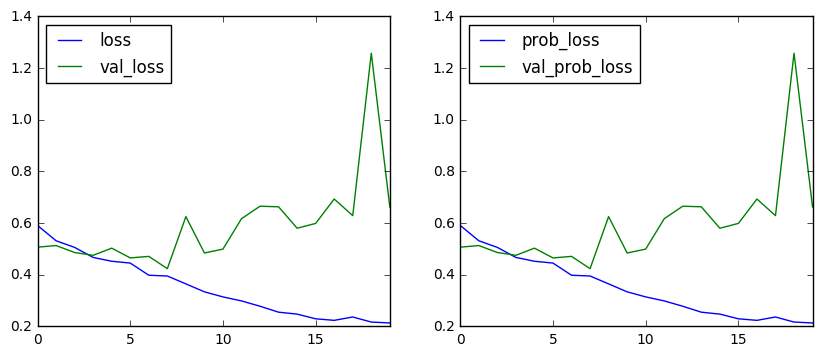

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pd.DataFrame({"loss": train_hist.history["loss"], "val_loss": train_hist.history["val_loss"]}).plot(ax=axes[0])
pd.DataFrame({"prob_loss": train_hist.history["prob_loss"], "val_prob_loss": train_hist.history["val_prob_loss"]}).plot(ax=axes[1])

In [9]:
model.model.load_weights(os.path.join(logdir, "model", modelname))

In [11]:
data_files = os.listdir(target_data_dir)
test_data_files = np.sort([f for f in data_files if "test" in f])
logger.info("#test_files = {}".format(test_data_files.size))
test_data = util.load_all_data(target_data_dir, "test")
logger.info("test_data.shape={}".format(test_data.shape))

2017-04-23 16:43:01,067 [INFO] __main__: #test_files = 502
2017-04-23 16:43:01,068 [INFO] data_util: Loading test data from /home/yujin/ts_prediction_keras/data/Dog_1 ...
2017-04-23 16:43:01,071 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0001.mat
2017-04-23 16:43:01,349 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0002.mat
2017-04-23 16:43:01,406 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0003.mat
2017-04-23 16:43:01,469 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0004.mat
2017-04-23 16:43:01,532 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0005.mat
2017-04-23 16:43:01,596 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0006.mat
2017-04-23 16:43:01,659 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog

In [12]:
preds = model.test_on_data(test_data)

In [15]:
output = pd.Series(preds, index=test_data_files)
output_file = os.path.join(logdir, "output_fold"+str(fold_i)+".csv")
output.to_csv(output_file)
logger.info("Test result written to {}.".format(output_file))

2017-04-23 16:49:19,909 [INFO] __main__: Test result written to ./log/Dog_1_20170423163401/output_fold0.csv.


In [18]:
import pickle

hist_file = os.path.join(logdir, "hist_fold"+str(fold_i)+".pkl")
with open(hist_file, "wb") as f:
    pickle.dump(train_hist.history, f)

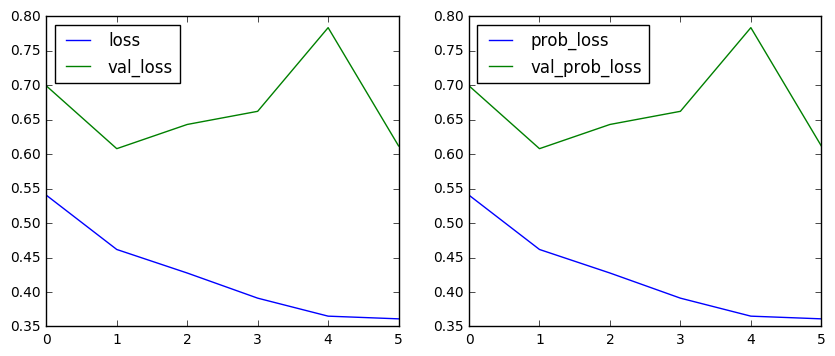

In [20]:
with open(hist_file, "rb") as f:
    hh = pickle.load(f)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pd.DataFrame({"loss": hh["loss"], "val_loss": hh["val_loss"]}).plot(ax=axes[0])
pd.DataFrame({"prob_loss": hh["prob_loss"], "val_prob_loss": hh["val_prob_loss"]}).plot(ax=axes[1])

In [22]:
layer_info = [(idx, layer.name, layer.output_shape) for idx, layer in enumerate(model.model.layers)]

logger.info("<Model architecture>")
for idx, name, shape in layer_info:
    logger.info("#{}: name={}, shape={}".format(idx, name, shape))

logger.info("<Model metrics>")
logger.info("metrics_names={}".format(model.model.metrics_names))

2017-04-23 15:57:57,166 [INFO] __main__: <Model architecture>
2017-04-23 15:57:57,168 [INFO] __main__: #0: name=data, shape=(None, 8000, 16)
2017-04-23 15:57:57,169 [INFO] __main__: #1: name=normalization, shape=(None, 8000, 16)
2017-04-23 15:57:57,171 [INFO] __main__: #2: name=conv1, shape=(None, 8000, 32)
2017-04-23 15:57:57,172 [INFO] __main__: #3: name=max_pooling1d_1, shape=(None, 2000, 32)
2017-04-23 15:57:57,173 [INFO] __main__: #4: name=pos_data1, shape=(None, 8000, 16)
2017-04-23 15:57:57,174 [INFO] __main__: #5: name=pos_data2, shape=(None, 8000, 16)
2017-04-23 15:57:57,174 [INFO] __main__: #6: name=conv2, shape=(None, 2000, 64)
2017-04-23 15:57:57,175 [INFO] __main__: #7: name=max_pooling1d_2, shape=(None, 1000, 64)
2017-04-23 15:57:57,176 [INFO] __main__: #8: name=conv3, shape=(None, 1000, 64)
2017-04-23 15:57:57,177 [INFO] __main__: #9: name=max_pooling1d_3, shape=(None, 500, 64)
2017-04-23 15:57:57,178 [INFO] __main__: #10: name=flatten, shape=(None, 32000)
2017-04-23 15:

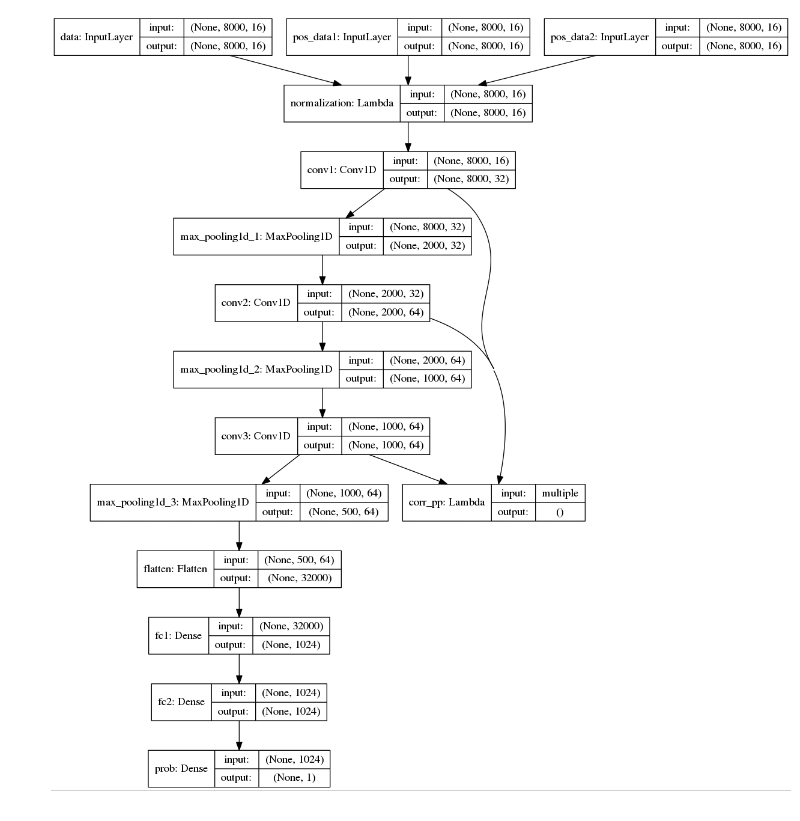

In [23]:
from keras.utils import plot_model
plot_model(model.model, to_file='model.png', show_shapes=True)
model_arch = plt.imread("model.png")
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(model_arch)
ax.set_axis_off()